# PyTorch AutoGrad

In [1]:
from typing import Tuple
import torch

## Matrix Factorisation using Gradient Descent

In [2]:
def gd_factorise_ad(A, rank, num_epochs=1000, lr=0.01):
    m, n = A.shape # m x n matrix
    Uh = torch.rand(m, rank, requires_grad=True) # m x r matrix
    Vh = torch.rand(n, rank, requires_grad=True) # n x r matrix
    for epoch in range(num_epochs):
        input = A
        pred = Uh @ Vh.T
        # loss
        loss = torch.nn.functional.mse_loss(input, pred, reduction='sum')
        # backward pass
        loss.backward()
        # gradient descent
        with torch.no_grad():
            Uh.data = Uh.data - lr * Uh.grad.data
            Vh.data = Vh.data - lr * Vh.grad.data
            Uh.grad.data.zero_()
            Vh.grad.data.zero_()
    return Uh, Vh

In [3]:
A = torch.tensor(
    [[0.3374, 0.6005, 0.1735],
     [3.3359, 0.0492, 1.8374],
     [2.9407, 0.5301, 2.2620]]
)

U, V = gd_factorise_ad(A, rank=2, num_epochs=2000, lr=0.01)
print('A:', A)
print('~A:', U@V.T)
reconstruct_loss = torch.nn.functional.mse_loss(A, (U@V.T))
print('Reconstruction error:', reconstruct_loss)

A: tensor([[0.3374, 0.6005, 0.1735],
        [3.3359, 0.0492, 1.8374],
        [2.9407, 0.5301, 2.2620]])
~A: tensor([[ 0.2245,  0.5212,  0.3592],
        [ 3.2531, -0.0090,  1.9737],
        [ 3.0378,  0.5983,  2.1023]], grad_fn=<MmBackward>)
Reconstruction error: tensor(0.0135, grad_fn=<MseLossBackward>)


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                 header=None)
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)
data = data.type(torch.float32)
# dtype=torch.float32
data.shape

torch.Size([150, 4])

In [37]:
U, V = gd_factorise_ad(data, rank=2, num_epochs=2000, lr=0.01)
# print('data:', A)
# print('~data:', U@V.T)
reconstruct_loss = torch.nn.functional.mse_loss(data, (U@V.T))
print('Reconstruction error:', reconstruct_loss)

Reconstruction error: tensor(0.0254, grad_fn=<MseLossBackward>)


In [38]:
# truncated SVD
U, S, V = torch.svd(data)
S[(S.shape[0] - 1)] = 0
reconstruct_loss = torch.nn.functional.mse_loss(data, (U@V.T))
print('Reconstruction error:', reconstruct_loss)

Reconstruction error: tensor(1.0201)


In [39]:
import matplotlib.pyplot as plt

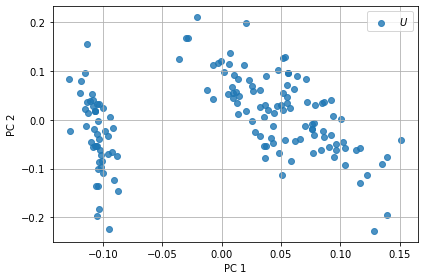

In [40]:
# SVD based PCA
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(U[:,0], U[:,1], alpha=.8, label='$U$')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.grid(True)
ax.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.savefig('svd_pca.png')

In [41]:
# Grad based PCA
U, V = gd_factorise_ad(data, rank=2, num_epochs=2000, lr=0.01)

In [42]:
# if we don't detach, matplotlib won't plot
U = U.detach()

reconstruct_loss = torch.nn.functional.mse_loss(data, (U@V.T))
print('Reconstruction error:', reconstruct_loss)

Reconstruction error: tensor(0.0254, grad_fn=<MseLossBackward>)


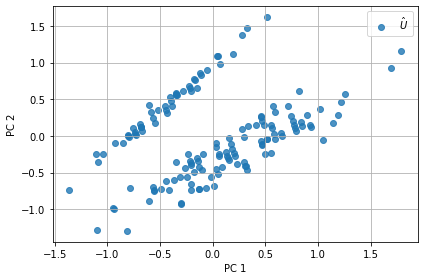

In [44]:

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(U[:,0], U[:,1], alpha=.8, label='$\hat{U}$')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.grid(True)
ax.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.savefig('gd_pca.png')

## A simple Multi-layer Perceptron

In [271]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(data_url, header=None)
df = df.sample(frac=1) # shuffle / 100% random sample with replacement

In [3]:
df[4].unique()

array(['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'], dtype=object)

In [4]:
# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

In [12]:
# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

In [91]:
# create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long) 
data_tr = alldata[:100] # training
data_va = alldata[100:] # validation

In [139]:
from tqdm.auto import tqdm

In [204]:
def eval_accuracy(predictions, labels):
    return ((torch.eq(predictions, labels).sum() / labels.shape[0]) * 100).item()

In [212]:
def mlp_predict(X, W1, W2, b1, b2):
    h1_linear = X @ W1 + b1
    h1 = torch.relu(h1_linear)
    h2_linear = h1 @ W2 + b2
    output = torch.relu(h2_linear)
    predictions = torch.argmax(output, dim=1) # for each row, which col has highest idx?
    return predictions

In [273]:
def mlp_train(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    print('Multi-layer perceptron:')
    print('  learning_rate:', lr)
    print('  epochs:', epochs)
    print('  X_train.shape:', X_train.shape)
    print('  y_train.shape:', y_train.shape)
    print('  X_test.shape:', X_test.shape)
    print('  y_test.shape:', y_test.shape)
    print('---------------------------------')
    
    # initialise weights
    W1 = torch.randn(4,12, requires_grad=True)
    W2 = torch.randn(12,3, requires_grad=True)

    # initialise bias
    b1 = torch.zeros(1)
    b2 = torch.zeros(1)
    
    # record loss over epoch
    losses = []
    
    # record training accuracy over epoch
    train_accuracy = []
    # record validation accuracy over epoch
    valid_accuracy = []
    
    print('Training model, please wait...')
    for epoch in tqdm(range(epochs)):
        # first hidden layer
        h1_linear = X_train @ W1 + b1
        h1 = torch.relu(h1_linear)
        # output layer
        h2_linear = h1 @ W2 + b2
        output = torch.relu(h2_linear)
        # loss
        loss = torch.nn.functional.cross_entropy(output, y_train) # softmax_cross_entropy
        # backprop
        loss.backward()
        # prevent pytorch from creating computational graph
        with torch.no_grad():
            # update weights using gradient descent
            W1.data = W1.data - lr * W1.grad.data
            W2.data = W2.data - lr * W2.grad.data
            # manually zero gradients after backward pass
            W1.grad.zero_()
            W2.grad.zero_()
        # track loss over epochs
        losses.append(loss.item())
        # track train accuracy over epochs
        pred = mlp_predict(X_train, W1, W2, b1, b2)
        acc = eval_accuracy(pred, y_train)
        train_accuracy.append(acc)
        pred_v = mlp_predict(X_test, W1, W2, b1, b2)
        acc_v = eval_accuracy(pred_v, y_test)
        valid_accuracy.append(acc_v)
        

    # test set loss
    h1_linear = X_test @ W1 + b1
    h1 = torch.relu(h1_linear)
    h2_linear = h1 @ W2 + b2
    output = torch.relu(h2_linear)
    predictions = torch.argmax(output, dim=1) # for each row, which col has highest idx?
    accuracy = eval_accuracy(predictions, y_test)
    print(f'Train accuracy: {acc}%')
    print(f'Validation accuracy: {accuracy}%')
    return output, predictions, train_accuracy, valid_accuracy, losses

In [278]:
score, pred, acc_train, acc_test, loss = mlp_train(data_tr, targets_tr, data_va, targets_va)

Multi-layer perceptron:
  learning_rate: 0.01
  epochs: 1000
  X_train.shape: torch.Size([100, 4])
  y_train.shape: torch.Size([100])
  X_test.shape: torch.Size([50, 4])
  y_test.shape: torch.Size([50])
---------------------------------
Training model, please wait...


  0%|          | 0/1000 [00:00<?, ?it/s]

Test accuracy: 87.0%
Validation accuracy: 90.0%


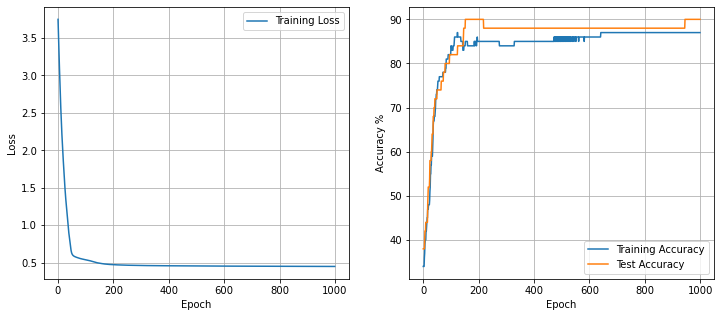

In [280]:
epochs = 1000
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
ax[0].plot(range(epochs), loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend(loc='best', frameon=True)

ax[1].plot(range(epochs), acc_train, label='Training Accuracy')
ax[1].plot(range(epochs), acc_test, label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].grid(True)
ax[1].legend(loc='best', frameon=True)
plt.savefig('mlp_loss_acc.png')

In [295]:
name_map = {k: v for k,v in enumerate(df[4].unique())}
name_map

{0: 'Iris-versicolor', 1: 'Iris-setosa', 2: 'Iris-virginica'}

In [296]:
named_pred = list(map((lambda x: name_map[x.item()]), pred))
named_pred

['Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-versicolor']

### Misc.

In [177]:
a = torch.randn(4,2)
print(a)
torch.argmax(a, dim=1)

tensor([[ 0.9836, -1.0120],
        [-2.3395,  2.5188],
        [ 0.4811, -0.0348],
        [ 0.5498, -0.0421]])


tensor([0, 1, 0, 0])

In [114]:
# quick reminder on how Python dictionary comprehensions work
dict1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
# dict1.items()
double_dict1 = {k:v*2 for (k,v) in dict1.items()}
double_dict1

{'a': 2, 'b': 4, 'c': 6, 'd': 8}

In [115]:
{k:v for v,k in enumerate(double_dict1)}

{'a': 0, 'b': 1, 'c': 2, 'd': 3}